In [1]:
# Importing the necessary libraries
import pandas as pd

# Reading the left and right datasets from CSV files
left_df = pd.read_csv('../data/left_dataset.csv')
right_df = pd.read_csv('../data/right_dataset.csv')

In [2]:
import pandas as pd
import recordlinkage
from recordlinkage.preprocessing import clean

In [3]:
left_df['name'] = clean(left_df['name'])
left_df['address'] = clean(left_df['address'])
left_df['city'] = clean(left_df['city'])
left_df['state'] = clean(left_df['state'])
right_df['name'] = clean(right_df['name'])
right_df['address'] = clean(right_df['address'])
right_df['city'] = clean(right_df['city'])
right_df['state'] = clean(right_df['state'])

In [4]:
# Handle postal codes as strings directly, stripping any non-numeric parts and padding if necessary
left_df['postal_code'] = left_df['postal_code'].astype(str).apply(lambda x: x.split('.')[0])

# First, ensure the zip_code column is treated as a string
right_df['zip_code'] = right_df['zip_code'].astype(str)

# Process zip_code to keep only the first part before the hyphen and ensure it's 5 digits
right_df['zip_code'] = right_df['zip_code'].apply(lambda x: x.split('-')[0].zfill(5))

left_df.fillna('unknown', inplace=True)

# Rename columns in right_df to match those in left_df
right_df.rename(columns={
    'zip_code': 'postal_code'  
}, inplace=True)

In [5]:
left_df['full_address'] = left_df['address'] + ' ' + left_df['city'] + ' ' + left_df['state'] + ' ' + left_df['postal_code']

right_df['full_address'] = right_df['address'] + ' ' + right_df['city'] + ' ' + right_df['state'] + ' ' + right_df['postal_code']

In [6]:
left_df

,entity_id,name,address,city,state,postal_code,categories,full_address
0,1,the ups store,87 grasso plaza shopping center,affton,mo,63123,"Shipping Centers, Local Services, Notaries, Ma...",87 grasso plaza shopping center affton mo 63123
1,2,st honore pastries,935 race st,philadelphia,pa,19107,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",935 race st philadelphia pa 19107
2,3,perkiomen valley brewery,101 walnut st,green lane,pa,18054,"Brewpubs, Breweries, Food",101 walnut st green lane pa 18054
3,4,sonic drive in,615 s main st,ashland city,tn,37015,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",615 s main st ashland city tn 37015
4,5,famous footwear,8522 eager road dierbergs brentwood point,brentwood,mo,63144,"Sporting Goods, Fashion, Shoe Stores, Shopping...",8522 eager road dierbergs brentwood point bren...
...,...,...,...,...,...,...,...,...
94580,94581,adelita taqueria restaurant,1108 s 9th st,philadelphia,pa,19147,"Restaurants, Mexican",1108 s 9th st philadelphia pa 19147
94581,94582,inspcenterthai clinical massage,2625 n meridian st unit 50,indianapolis,in,46208,"Massage Therapy, Rolfing, Beauty & Spas, Refle...",2625 n meridian st unit 50 indianapolis in 46208
94582,94583,wild birds unlimited,2813 bransford ave,nashville,tn,37204,"Pets, Nurseries & Gardening, Pet Stores, Hobby...",2813 bransford ave nashville tn 37204
94583,94584,claires boutique,6020 e 82nd st ste 46,indianapolis,in,46250,"Shopping, Jewelry, Piercing, Toy Stores, Beaut...",6020 e 82nd st ste 46 indianapolis in 46250


In [7]:
# Import the recordlinkage module
import recordlinkage

# Create a new column for the block key
left_df['block_key'] = left_df['address'].str[0] + left_df['name'].str[0] + left_df['state'] + left_df['postal_code'].str[:3]
right_df['block_key'] = right_df['address'].str[0] + right_df['name'].str[0] + right_df['state'] + right_df['postal_code'].str[:3]

# Create an indexer object
indexer = recordlinkage.Index()

# Add a blocking condition on the new column
indexer.block('block_key')

# Compute the candidate links
candidate_links = indexer.index(left_df, right_df)

In [8]:
# Import the Compare class from the recordlinkage module
from recordlinkage import Compare

# Create a compare object
compare_cl = Compare()

# Define the columns to compare and the method to use
compare_cl.string('name', 'name', method='jarowinkler',label='name_similarity')
compare_cl.string('full_address', 'full_address', method='jarowinkler',label='full_address_similarity')

# Compute the comparison vectors
features = compare_cl.compute(candidate_links, left_df, right_df)

In [9]:
features

name_similarity  full_address_similarity
0     36645         0.644943                 0.665718
      37026         0.638177                 0.644314
      37155         0.677253                 0.632210
      37158         0.647066                 0.663491
      37161         0.647066                 0.613728
...                      ...                      ...
94584 25856         0.547619                 0.543012
      25907         0.467787                 0.597171
      26096         0.519669                 0.555745
      26437         0.503968                 0.587597
      26565         0.427579                 0.652263

[6845983 rows x 2 columns]

In [10]:
scores = features.mean(axis=1)

In [11]:
# Create a DataFrame for the matches and their scores
matches_df = pd.DataFrame({'left_index': features.index.get_level_values(0), 'right_index': features.index.get_level_values(1), 'score': scores})

# Filter the matches with a score of 0.8 or higher
high_confidence_matches = matches_df[matches_df['score'] >= 0.8]

# Merge the high-confidence matched records
result = pd.merge(high_confidence_matches, left_df, left_on='left_index', right_index=True)
result = pd.merge(result, right_df, left_on='right_index', right_index=True, suffixes=('_left', '_right'))

In [12]:
result.head()

left_index  right_index     score  entity_id           name_left  \
1  75686           1        75686  0.814987          2  st honore pastries   
7  81911           7        81911  0.825429          8      sonic drive in   
   84020           7        84020  0.899741          8      sonic drive in   
14 51941          14        51941  0.809643         15                 bap   
19 87105          19        87105  0.806349         20  the green pheasant   

                 address_left     city_left state_left postal_code_left  \
1  75686          935 race st  philadelphia         pa            19107   
7  81911  2312 dickerson pike     nashville         tn            37207   
   84020  2312 dickerson pike     nashville         tn            37207   
14 51941        1224 south st  philadelphia         pa            19147   
19 87105        215 1st ave s     nashville         tn            37201   

                                                 categories  ...  \
1  75686  Restaurants, Food, Bubble Tea, Coffee & Tea, B...  ...   
7  81911  Ice Cream & Frozen Yogurt, Fast Food, Burgers,...  ...   
   84020  Ice Cream & Frozen Yogurt, Fast Food, Burgers,...  ...   
14 51941                                Korean, Restaurants  ...   
19 87105                     Restaurants, Japanese, Seafood  ...   

         block_key_left business_id  \
1  75686        9spa191       75687   
7  81911        2stn372       81912   
   84020        2stn372       84021   
14 51941        1bpa191       51942   
19 87105        2ttn372       87106   

                                           name_right        address_right  \
1  75686                      szechuan four river inc          936 race st   
7  81911         sonic drive in nashville melrose llc   2501 franklin road   
   84020  sonic drive in nashville dickerson road llc  2312 dickerson road   
14 51941                 buell kratzer powell limited       1525 locust st   
19 87105                        the oriental shop inc    2121 bandywood dr   

            city_right state_right postal_code_right  size  \
1  75686  philadelphia          pa             19107   4.0   
7  81911     nashville          tn             37204  24.0   
   84020     nashville          tn             37207  21.0   
14 51941  philadelphia          pa             19102   9.0   
19 87105     nashville          tn             37215   4.0   

                              full_address_right block_key_right  
1  75686       936 race st philadelphia pa 19107         9spa191  
7  81911   2501 franklin road nashville tn 37204         2stn372  
   84020  2312 dickerson road nashville tn 37207         2stn372  
14 51941    1525 locust st philadelphia pa 19102         1bpa191  
19 87105    2121 bandywood dr nashville tn 37215         2ttn372  

[5 rows x 21 columns]

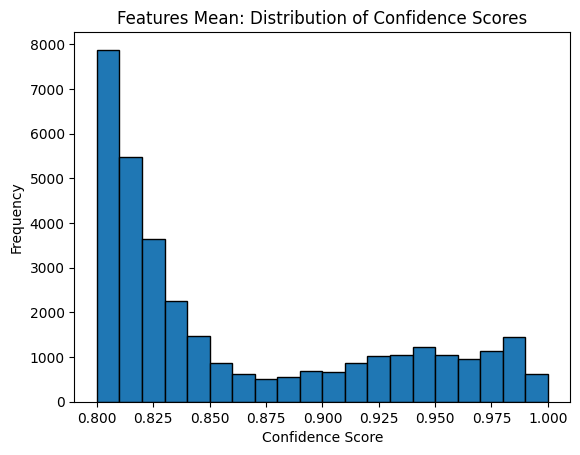

In [24]:
import matplotlib.pyplot as plt

scores = result['score']

# Create a histogram
plt.hist(scores, bins=20, edgecolor='black')

# Add title and labels
plt.title('Features Mean: Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [19]:
recordlinkage_submission = result[['entity_id', 'business_id', 'score']].copy()
recordlinkage_submission.columns = ['left_dataset', 'right_dataset', 'confidence_score']
recordlinkage_submission['confidence_score'] = recordlinkage_submission['confidence_score'].round(2)
recordlinkage_submission

left_dataset  right_dataset  confidence_score
1     75686             2          75687              0.81
7     81911             8          81912              0.83
      84020             8          84021              0.90
14    51941            15          51942              0.81
19    87105            20          87106              0.81
...                   ...            ...               ...
94559 74490         94560          74491              0.82
94570 72779         94571          72780              0.81
      75425         94571          75426              0.83
94578 80356         94579          80357              0.97
94582 85068         94583          85069              0.80

[33981 rows x 3 columns]

In [25]:
recordlinkage_submission.to_csv('../data/recordlinkage2_submission.csv', index=False)

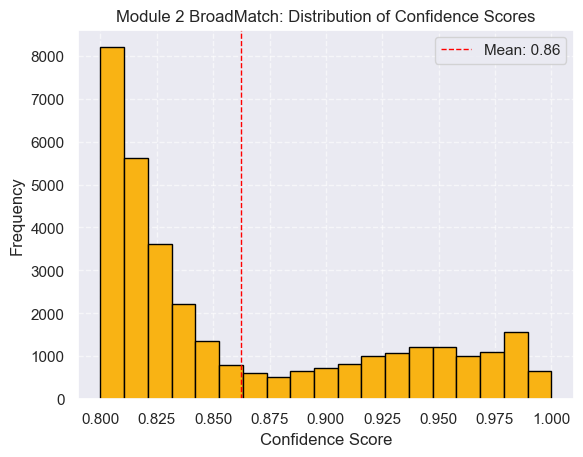

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Using seaborn styles
sns.set()

scores = result['score']

# Create a histogram with more bins
bins = np.linspace(min(scores), max(scores), 20)
plt.hist(scores, bins=bins, edgecolor='black', color='#f9b314')

# Calculate the mean and add a vertical line
mean_score = np.mean(scores)
plt.axvline(mean_score, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_score:.2f}')

# Add title and labels with sans-serif font
plt.title('Module 2 BroadMatch: Distribution of Confidence Scores', fontname='sans-serif')
plt.xlabel('Confidence Score', fontname='sans-serif')
plt.ylabel('Frequency', fontname='sans-serif')

# Add legend to explain the red dashed line
plt.legend()

# Customize grid
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()